# Neural Network Implementation for Iris Dataset Classification

In this notebook we implement 3 Layered Multiclass Logistic Regression Neural Network using Adam's Algorthim. The goal is to predict Iris' Species based on the factors:

* SepalLengthCm

* SepalWidthCm

* PetalLengthCm 

* PetalWidthCm

## 1. Import Required Libraries

Import the required libraries.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Load the Dataset

Load the dataset from Kaggle.

In [25]:
data = pd.read_csv('Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


## 3. Process the Data

Clean the data convert to Numpy Arrays.

In [26]:
mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
data['Species'] = data['Species'].str.strip().map(mapping)

x_train = data.drop(['Id', 'Species'], axis=1).values
y_train = data['Species'].values

length = len(y_train)
print(f"Length of the data: {length}")

shape = x_train.shape
print(f"Shape of the data: {shape}")

number_of_classes = 3
print(f"Number of classes: {number_of_classes}")

x_features = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
number_of_features = len(x_features)
print(f"Number of features: {number_of_features}")

data.head()

Length of the data: 150
Shape of the data: (150, 4)
Number of classes: 3
Number of features: 4


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0


## 4. One-Hot Encoding of the Labels

The target variable is one-hot encoded to match the format needed for multi-class classification. This is done by setting the corresponding class index to 1 and others to 0.

In [27]:
# Function to perform one hot encoding on y_train
def one_hot_encoding(y, m, n):
    y_one_train = np.zeros((m, n))
    y_one_train[np.arange(m), y] = 1
    return y_one_train

In [28]:
y_one_train = one_hot_encoding(y_train, length, number_of_classes)

## 5. Weight Initialization

Using He initialization for ReLU networks because it ensures that the gradients maintain a healthy variance throughout the layers, avoiding vanishing gradients:
$$
W_l = \text{randn}(n_{l}, n_{l-1}) \times \sqrt{\frac{2}{n_{l-1}}}
$$
where $n_l$ is the number of neurons on each layer l.

In [29]:
# Function to initialize the weights and biases
def initialize_parameters(input_size, hidden1_size, hidden2_size, output_size):
    np.random.seed(42)
    w1 = np.random.randn(hidden1_size, input_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((hidden1_size, 1))
    w2 = np.random.randn(hidden2_size, hidden1_size) * np.sqrt(2 / hidden1_size)
    b2 = np.zeros((hidden2_size, 1))
    w3 = np.random.randn(output_size, hidden2_size) * np.sqrt(2 / hidden2_size)
    b3 = np.zeros((output_size, 1))
    
    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2, "w3": w3, "b3": b3}

In [30]:
input_size = 4
hidden1_size = 4
hidden2_size = 5
output_size = 3

parameters = initialize_parameters(input_size, hidden1_size, hidden2_size, output_size)

## 6. Activation Functions

### a. ReLU Activation

The Rectified Linear Unit activation function is applied in the hidden layers to introduce non-linearity:
$$
ReLU(z)=max(0,z)
$$

In [31]:
def relu(z):
    return np.maximum(0, z)

### b. Softmax Activation

The softmax function is used at the output layer to normalize the output to a probability distribution:
$$
\text{Softmax}(Z_i) = \frac{e^{Z_i}}{\sum_{j=1}^{K} e^{Z_j}}
$$

In [44]:
def softmax(z):
    # Prevent overflow by clipping the values of z
    z = np.clip(z, -500, 500)  # Clip values between -500 and 500 to prevent overflow
    exp_z = np.exp(z - np.max(z))  # For numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

## 7. Forward Propogation

The forward propagation process follows these equations:

### a. First Hidden Layer
$$
Z^{[1]} = W^{[1]}X + b^{[1]} \newline
A^{[1]} = \text{ReLU}(Z^{[1]}) = \max(0, Z^{[1]})
$$

### b. Second Hidden Layer
$$
Z^{[2]} = W^{[2]}A^{[1]} + b^{[2]} \newline
A^{[2]} = \text{ReLU}(Z^{[2]}) = \max(0, Z^{[2]})
$$

### c. Output Layer
$$
Z^{[3]} = W^{[3]}A^{[2]} + b^{[3]} \newline
A^{[3]} = \text{Softmax}(Z^{[3]}) = \frac{e^{Z^{[3]}}}{\sum_{j=1}^{3} e^{Z^{[3]}_j}}
$$

In [33]:
def forward_propagation(X, parameters):
    w1, b1 = parameters["w1"], parameters["b1"]
    w2, b2 = parameters["w2"], parameters["b2"]
    w3, b3 = parameters["w3"], parameters["b3"]

    # First hidden layer
    z1 = np.dot(w1, X.T) + b1
    a1 = relu(z1)   # relu activation

    # Second hidden layer
    z2 = np.dot(w2, a1) + b2 
    a2 = relu(z2)   # relu activation

    # Output layer
    z3 = np.dot(w3, a2) + b3
    a3 = softmax(z3)    # softmax activation

    cache = {"z1": z1, "a1": a1, "z2": z2, "a2": a2, "z3": z3, "a3": a3}
    return a3, cache

## 8. Cost Function

Using categorical cross-entropy loss:
$$
J = -\frac{1}{m}\sum_{i=1}^m\sum_{j=1}^3 y_{ij}\log(a_{ij})
$$

In [34]:
def compute_cost(a3, y, epsilon=1e-8):
    m = y.shape[0]
    # Add epsilon to avoid log(0) and log of very small values
    a3 = np.clip(a3, epsilon, 1 - epsilon)  # Clip the values of a3 to prevent 0 or 1
    log_probs = -np.log(a3.T[range(m), np.argmax(y, axis=1)])
    cost = np.sum(log_probs) / m
    return cost

In [35]:
def backward_propagation(parameters, cache, x, y, m):
    w2, w3 = parameters['w2'], parameters['w3']

    a1, a2, a3 = cache['a1'], cache['a2'], cache['a3']
    z1, z2 = cache['z1'], cache['z2']

    dz3 = a3.T - y

    dw3 = np.dot(dz3.T, a2.T) / m
    db3 = np.sum(dz3.T, axis=1, keepdims=True) / m

    da2 = np.dot(dz3, w3)  # Propagate to second hidden layer
    dz2 = da2 * (z2 > 0).T   # ReLU derivative (element-wise)
    
    dw2 = np.dot(dz2.T, a1.T) / m  # Correct the order: dz2 and a1.T
    db2 = np.sum(dz2.T, axis=1, keepdims=True) / m

    da1 = np.dot(dz2, w2)  # Propagate to first hidden layer
    dz1 = da1 * (z1 > 0).T   # ReLU derivative (element-wise)
    dw1 = np.dot(dz1.T, x) / m
    db1 = np.sum(dz1.T, axis=1, keepdims=True) / m

    gradients = {'dw1': dw1, 'db1': db1, 'dw2': dw2, 'db2': db2, 'dw3': dw3, 'db3': db3}
    return gradients

In [36]:
def update_parameters(parameters, gradients, v, s, t, alpha, b1, b2, e, clip_value = 5):
    t = t + 1
    for key in parameters.keys():
        v[key] = b1 * v[key] + (1 - b1) * gradients['d' + key]
        s[key] = b2 * s[key] + (1 - b2) * (gradients['d' + key] ** 2)

        v_c = v[key] / (1 - b1 ** t)
        s_c = s[key] / (1 - b2 ** t)

        # Gradient clipping
        v_c = np.clip(v_c, -clip_value, clip_value)
        s_c = np.clip(s_c, -clip_value, clip_value)

        parameters[key] -= (alpha * v_c) / (np.sqrt(s_c) + e)
    return parameters, v, s

In [37]:
def train(x, y, input_size, hidden1_size, hidden2_size, output_size, alpha, epochs, m, b1, b2, e):
    parameters = initialize_parameters(input_size, hidden1_size, hidden2_size, output_size)
    v = {key: np.zeros_like(val) for key, val in parameters.items()}
    s = {key: np.zeros_like(val) for key, val in parameters.items()}
    costs = []

    for i in range(epochs):
        a3, cache = forward_propagation(x, parameters)
        cost = compute_cost(a3, y)
        gradients = backward_propagation(parameters, cache, x, y, m)
        parameters, v, s = update_parameters(parameters, gradients, v, s, i, alpha, b1, b2, e)
        if i % 100 == 0:
            costs.append(cost)
    return parameters, costs

In [38]:
alpha = 0.001
epochs = 1000
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
parameters, costs = train(x_train, y_one_train, input_size, hidden1_size, hidden2_size, output_size, alpha, epochs, length, beta1, beta2, epsilon)

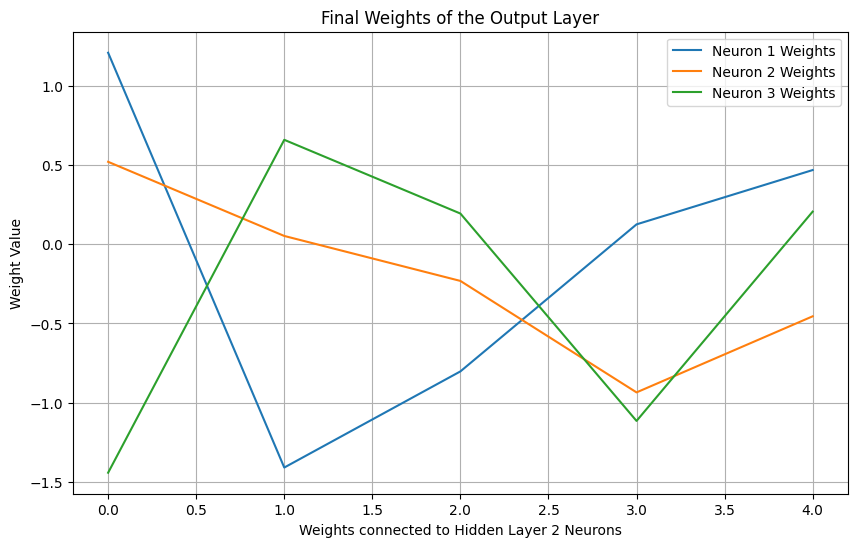

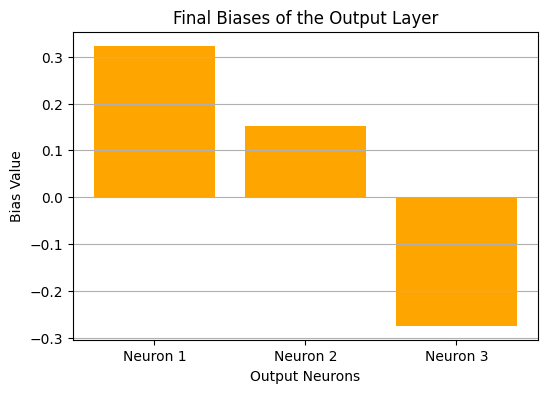

In [39]:
def plot_weights_and_biases(parameters):
    w3 = parameters["w3"]  # Final weights for the output layer
    b3 = parameters["b3"]  # Final biases for the output layer
    
    # Plot weights
    plt.figure(figsize=(10, 6))
    for i in range(w3.shape[0]):  # For each output neuron
        plt.plot(w3[i, :], label=f'Neuron {i+1} Weights')
    
    plt.title("Final Weights of the Output Layer")
    plt.xlabel("Weights connected to Hidden Layer 2 Neurons")
    plt.ylabel("Weight Value")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot biases
    plt.figure(figsize=(6, 4))
    plt.bar(range(b3.shape[0]), b3.flatten(), color='orange')
    plt.title("Final Biases of the Output Layer")
    plt.xlabel("Output Neurons")
    plt.ylabel("Bias Value")
    plt.xticks(range(b3.shape[0]), [f"Neuron {i+1}" for i in range(b3.shape[0])])
    plt.grid(axis='y')
    plt.show()

# Call the function to plot
plot_weights_and_biases(parameters)

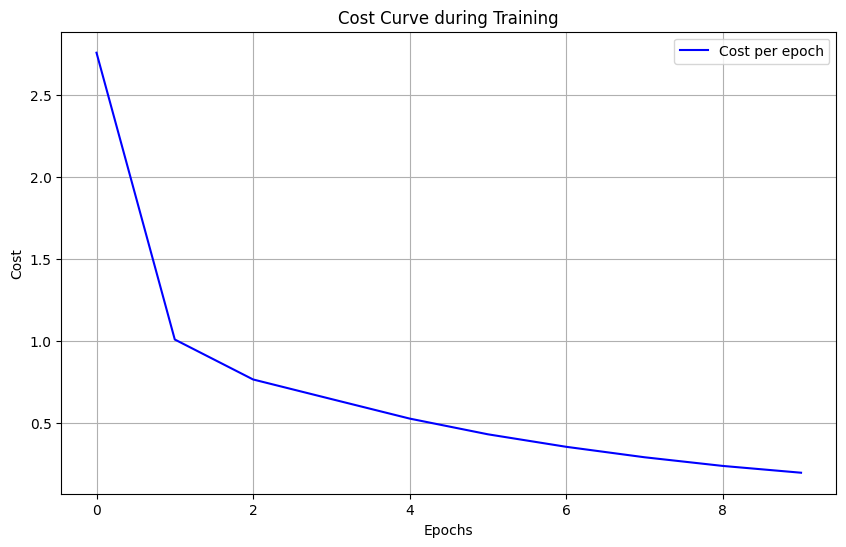

In [40]:
def plot_cost_curve(costs):
    plt.figure(figsize=(10, 6))
    plt.plot(costs, color='blue', label='Cost per epoch')
    plt.title("Cost Curve during Training")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming `costs` is already obtained from the training process
plot_cost_curve(costs)

In [42]:
def evaluate_model(X, y_true, parameters):
    # Get predictions
    predictions, _ = forward_propagation(X, parameters)
    predicted_classes = np.argmax(predictions, axis=0)
    true_classes = np.argmax(y_true, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predicted_classes == true_classes)
    
    return accuracy, predicted_classes, true_classes

# Add this after training
accuracy, pred_classes, true_classes = evaluate_model(x_train, y_one_train, parameters)
print(f"Training Accuracy: {accuracy*100:.2f}%")

Training Accuracy: 95.33%
